# Project 2 - Binary Classification Comparative Methods

# ECE M148

## Damien Ha, UID 905539967

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 


<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Submission Details

**Project is due May 17th at 12:00 pm (Wednesday Noon). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend downloading [Latex](https://www.latex-project.org/) and print the notebook using Latex.**

## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib
import os
import time
#Sklearn classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.svm import SVC  #SVM classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

from matplotlib import pyplot
import itertools

%matplotlib inline

#Sets random seed
import random 
random.seed(42) 

os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [4]:
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)



In [5]:

def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())

# Example Project

In this part, we will go over how to perform a Binary classification task using a variety of models. We will provide examples of how to train and evaluate these models. 

## Dataset Description

Healthcare is an important industry that uses machine learning to aid doctors in diagnosing many different kinds of illnesses and diseases. For this example project, we will be using the [Breast Cancer Wisconsin Dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) to determine whether a mass found in a body is benign or malignant. 

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 

Feature Information:

Column 1: ID number

Column 2: Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

    1. radius (mean of distances from center to points on the perimeter)
    2. texture (standard deviation of gray-scale values)
    3. perimeter
    4. area
    5. smoothness (local variation in radius lengths)
    6. compactness (perimeter^2 / area - 1.0)
    7. concavity (severity of concave portions of the contour)
    8. concave points (number of concave portions of the contour)
    9. symmetry
    10. fractal dimension ("coastline approximation" - 1)

Due to the statistical nature of the test, we are not able to get exact measurements of the previous values. Instead, the dataset contains the mean and standard error of the real-valued features. 

Columns 3-12 present the mean of the measured values

Columns 13-22 present the standard error of the measured values

## Load and Analyze the dataset

In [6]:
#Load Data
data = pd.read_csv('datasets/breast_cancer_data.csv')

Always look at your dataset after loading it. Use information from .describe and .info to learn more about the dataset.

In [7]:
data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115


In [8]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    int64  
 1   diagnosis               569 non-null    object 
 2   radius_mean             569 non-null    float64
 3   texture_mean            569 non-null    float64
 4   perimeter_mean          569 non-null    float64
 5   area_mean               569 non-null    float64
 6   smoothness_mean         569 non-null    float64
 7   compactness_mean        569 non-null    float64
 8   concavity_mean          569 non-null    float64
 9   concave points_mean     569 non-null    float64
 10  symmetry_mean           569 non-null    float64
 11  fractal_dimension_mean  569 non-null    float64
 12  radius_se               569 non-null    float64
 13  texture_se              569 non-null    float64
 14  perimeter_se            569 non-null    fl

While .info shows that every entry has 569 non-null and there are 569 entries, it is good to explicitly check for nulls.

In [10]:
data.isnull().sum()

id                        0
diagnosis                 0
radius_mean               0
texture_mean              0
perimeter_mean            0
area_mean                 0
smoothness_mean           0
compactness_mean          0
concavity_mean            0
concave points_mean       0
symmetry_mean             0
fractal_dimension_mean    0
radius_se                 0
texture_se                0
perimeter_se              0
area_se                   0
smoothness_se             0
compactness_se            0
concavity_se              0
concave points_se         0
symmetry_se               0
fractal_dimension_se      0
dtype: int64

Awesome! No need for imputation!

While we are looking at the dataset, we shall remove the "id" column.

In [11]:
data = data.drop(["id"],axis= 1)

### Looking at the target labels 

For this project, we wish to classify the diagnosis column.

In [12]:
data["diagnosis"]

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

We need to transform this column into numerical column so that we may use them in our models. To do this, we will employ the LabelEncoder to automatically transform all the target label. 

In [13]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 

data['diagnosis'] = le.fit_transform(data['diagnosis'])
print(le.classes_)

['B' 'M']


In [14]:
data['diagnosis']

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

### Let's look at a histogram of the full dataset.

Its always good to get a global view of your datasets by looking at their histograms. You might see some interesting trends.

array([[<Axes: title={'center': 'diagnosis'}>,
        <Axes: title={'center': 'radius_mean'}>,
        <Axes: title={'center': 'texture_mean'}>,
        <Axes: title={'center': 'perimeter_mean'}>,
        <Axes: title={'center': 'area_mean'}>],
       [<Axes: title={'center': 'smoothness_mean'}>,
        <Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concavity_mean'}>,
        <Axes: title={'center': 'concave points_mean'}>,
        <Axes: title={'center': 'symmetry_mean'}>],
       [<Axes: title={'center': 'fractal_dimension_mean'}>,
        <Axes: title={'center': 'radius_se'}>,
        <Axes: title={'center': 'texture_se'}>,
        <Axes: title={'center': 'perimeter_se'}>,
        <Axes: title={'center': 'area_se'}>],
       [<Axes: title={'center': 'smoothness_se'}>,
        <Axes: title={'center': 'compactness_se'}>,
        <Axes: title={'center': 'concavity_se'}>,
        <Axes: title={'center': 'concave points_se'}>,
        <Axes: title={'cent

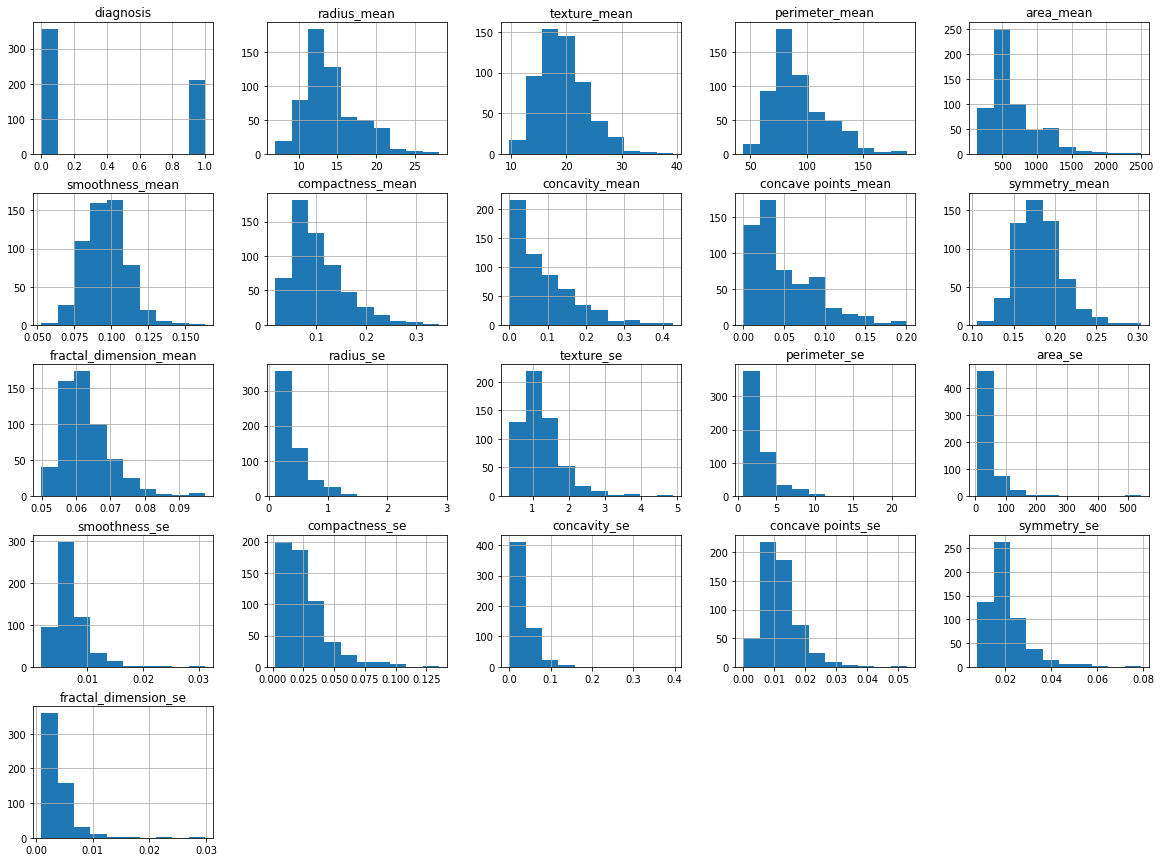

In [15]:
data.hist(figsize = (20,15))

From the histograms, we can see some interesting trends. Possible observations:

- Many of the _se columns indicate a heavy skewness towards low values and have large tails
- Many of the _mean columns look more Gaussian in shape
- There is a large disparity between the ranges of certain features. For example, radius mean can go from 0 to 25 while smoothness_mean is in the range [0.050,0.150]. This indicates we will have to normalize or standardize the features if the models are sensitive to such measures.

### Looking at the correlation matrix to get an idea about which features are important

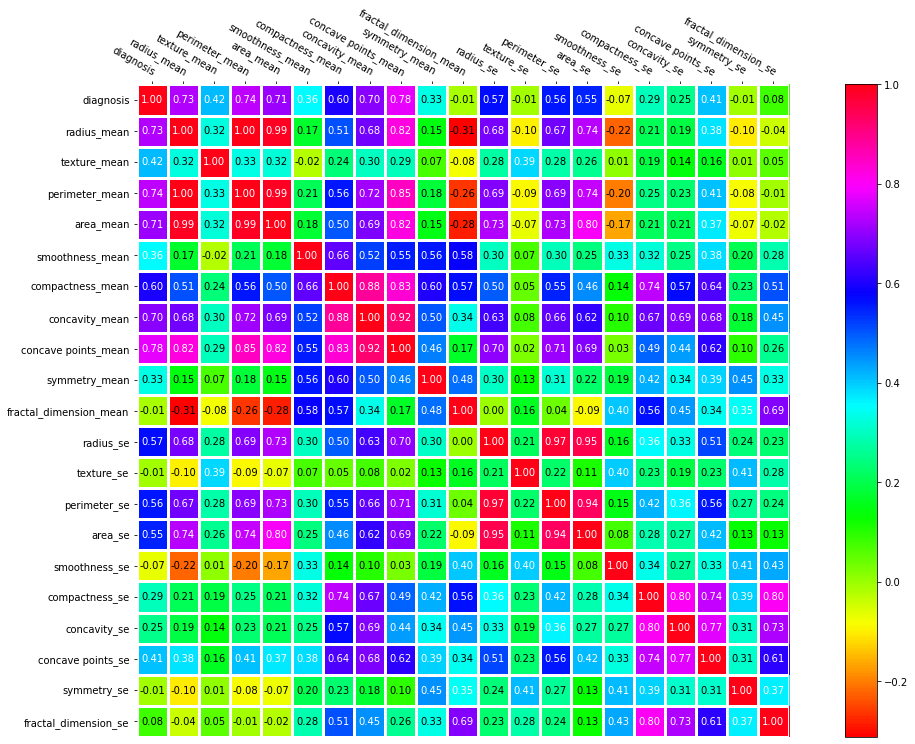

In [16]:
correlations = data.corr()
columns = list(data)
#Creates the heatmap
heatmap(correlations.values,columns,columns,figsize = (20,12),cmap="hsv")


In [17]:
#Let's specifically look at the correlations of our target feature
correlations["diagnosis"].sort_values(ascending=False)

diagnosis                 1.000000
concave points_mean       0.776614
perimeter_mean            0.742636
radius_mean               0.730029
area_mean                 0.708984
concavity_mean            0.696360
compactness_mean          0.596534
radius_se                 0.567134
perimeter_se              0.556141
area_se                   0.548236
texture_mean              0.415185
concave points_se         0.408042
smoothness_mean           0.358560
symmetry_mean             0.330499
compactness_se            0.292999
concavity_se              0.253730
fractal_dimension_se      0.077972
symmetry_se              -0.006522
texture_se               -0.008303
fractal_dimension_mean   -0.012838
smoothness_se            -0.067016
Name: diagnosis, dtype: float64

We can see that there is a lot of correlation between the features and the target label. Thus, we can expect to learn something from the data

### When doing classification, check if classes are heavily imbalanced.

It is important that the dataset does not prefer one class over any others. Otherwise, it may bias the model to not learn the minority classes well. 

Lets use a histogram and count the number of elements in each class.

diagnosis
0    357
1    212
Name: count, dtype: int64

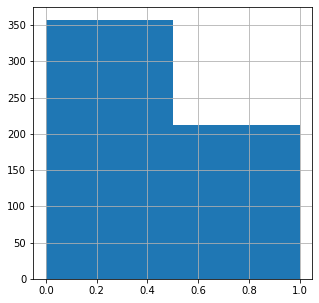

In [18]:
data['diagnosis'].hist(bins=2, figsize=(5,5))
data['diagnosis'].value_counts()

There is a bit of an imbalance which is something to keep in mind if we find that our models do not perform well on the minority classes. For our purposes, this imbalance is not big enough to be an issue so we will not perform balancing techniques for this dataset.

Since the dataset is small though, we want to be careful when making training and testing splits to ensure that there is enough of each class for both splits. We will show how to perform this shortly.

### Setting up the data

Before starting any model training, we have to split up the target labels from our features.

In [19]:
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis = 1)

Now, we also split the data into training and testing data. To ensure that there is not an imbalance of classes in the training and testing set, we will use the stratify parameter in train_test_split to perform stratified sampling on the data (Recall from lecture how stratified sampling is performed).

In [20]:
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

Note that we named the input feature data as raw to indicate that there has been no pre-processing on them such as standardization. Shortly, we will show the affect that pre-processing has on the performance of the model.

Let us quickly test that the splits are somewhat balanced.

diagnosis
0    285
1    170
Name: count, dtype: int64

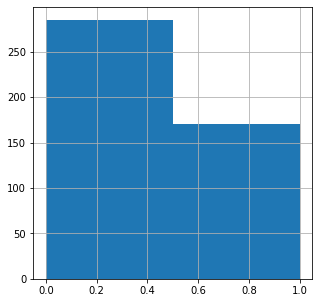

In [21]:
#Training classes
target.hist(bins=2, figsize=(5,5))
target.value_counts()

diagnosis
0    72
1    42
Name: count, dtype: int64

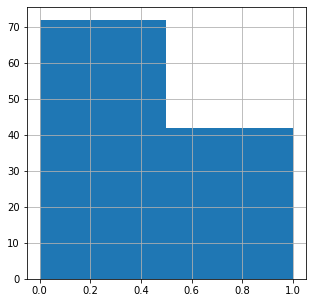

In [22]:
#Testing classes
target_test.hist(bins=2, figsize=(5,5))
target_test.value_counts()

We can see that the class balance is about the same as before the split. In fact, we can see that if a classifier just guessed class 0, it would have an accuracy of $100 * \frac{72}{72+42} = 63.15\%$. We can consider this the baseline accuracy to compare against.

## Models for Classification: KNN

For our first model, we will use KNN classfication. This is a model we have seen many times throughout the course and it would be interesting to see how well it performs.

### Simple KNN classification with K = 3

Let us try KNN on the raw data with simply 3 nearest neighbors. We use the sklearn [metric library](https://scikit-learn.org/stable/modules/model_evaluation.html) to calculate the measures of interest. In this case, we focus on accuracy.

In [23]:
# k-Nearest Neighbors algorithm
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_raw, target)
predicted = knn.predict(test_raw)

In [24]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.877193


We can see that there is already a huge improvement in accuracy on comparison to the baseline of 63.15%. Let's see the effect that standardizing the input features would have on the KNN performance.

### Affect of pre-processing on KNN

In [25]:
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])


#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) #Note that there is no fit calls

In [26]:
# k-Nearest Neighbors algorithm
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train, target)
testing_result = knn.predict(test)
predicted = knn.predict(test)

In [27]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.921053


We can see that with pre-processing we were able to get a much better classification accuracy. 

Here we only used StandardScaler. Lets see if other pre-processing techniques could have also worked. As such, lets  look at MinMaxScaler and Normalizer:

In [28]:

preprocessors = [StandardScaler(),MinMaxScaler(),Normalizer() ]

for pre in preprocessors:
    pipeline = Pipeline([
        ('preprocessor', pre)
    ])


    #Transform raw data 
    train = pipeline.fit_transform(train_raw)
    test = pipeline.transform(test_raw) #Note that there is no fit calls
    # k-Nearest Neighbors algorithm
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(train, target)
    testing_result = knn.predict(test)
    predicted = knn.predict(test)
    
    print(pre)
    print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

StandardScaler()
Accuracy:    0.903509
MinMaxScaler()
Accuracy:    0.912281
Normalizer()
Accuracy:    0.885965


We can see that MinMaxScaler had the same performance as StandardScaler. Yet, Normalizer did not improve the model. 

### Visualizing decision boundaries  for KNN

Its always nice to see the decision boundaries a model decides upon. Let's see how the decision boundary changes as function of k when only using the two most correlated features to the target labels: concave_points_mean and perimeter_mean.

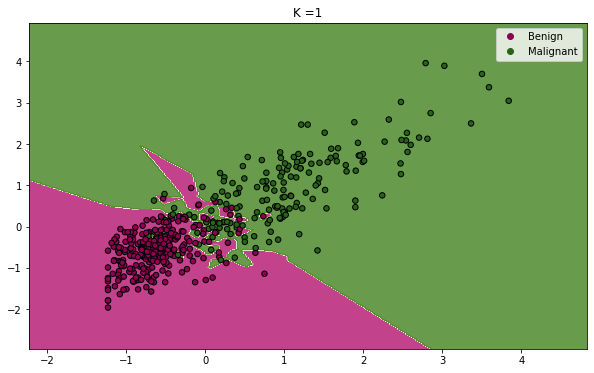

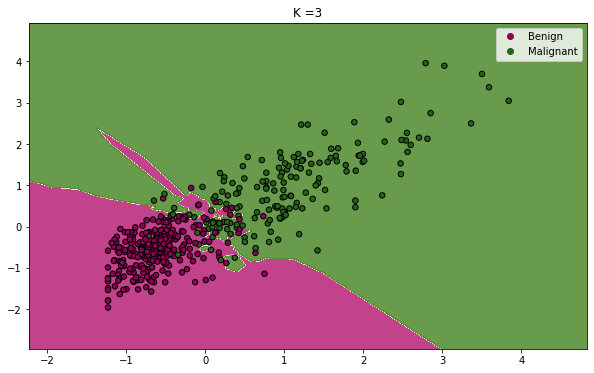

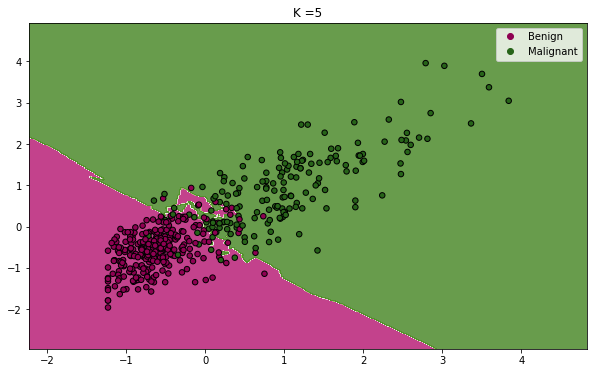

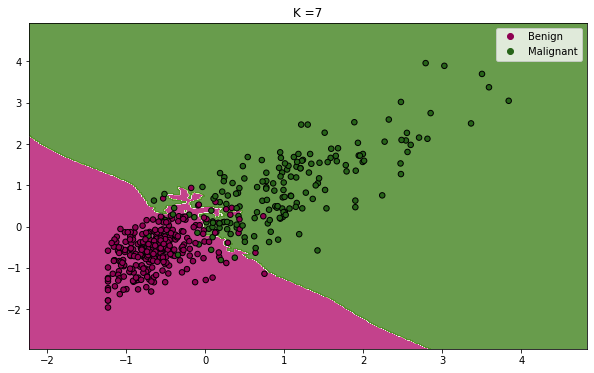

In [29]:
#Extract first two features and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

k_r  = [1,3,5,7]
for k in k_r:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_2, target)
    draw_contour(train_2,target,knn, class_labels = ['Benign', 'Malignant'])

    plt.title(f"K ={k}")

We can see that as k gets larger, the decision boundary gets smoother. 

## Models for Classification: Logistic Regression

While KNN is a very powerful model, it does come with a few issues such as 

- Require storing the full training dataset
- Prediction is done by comparing new sample will all samples in training set which is time-consuming

These issues arise because KNN is a **non-parametric** model which means that it does not summarize the data into a finite set of parameters.

Let us now look at Logistic Regression which is an example of a **parametric** model.

### Simple Logistic Regression


First, let us see how logistic regression performs without any regularization.

In [30]:
log_reg = LogisticRegression(penalty = "l2",max_iter = 1000, solver = "lbfgs", C=(10**30)/1) 
#C is choosen to be high to remove regularization
#We could have chosen penalty = "none" since lbfgs supports it but this option is not possible for all solvers.

log_reg.fit(train_raw, target)
testing_result = log_reg.predict(test_raw)
predicted = log_reg.predict(test_raw)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.956140


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can see that Logistic Regression is actually performing much better than any of the KNN models we tried. We can also see the parameters that the model learned.

In [31]:
#Parameters for each feature
log_reg.coef_

array([[ 7.69693873e+00,  4.92498510e-01, -1.44965140e+00,
         2.07999028e-02,  4.05644869e+01,  2.33607683e+01,
         6.18991927e+01,  5.95797939e+01,  3.81056947e+01,
         2.17465321e-01, -3.18292770e+01, -2.56236337e+00,
         9.40015597e-01,  3.93506405e-01, -1.39003356e+00,
        -4.39088989e+01, -6.15560497e+01, -6.74554995e+00,
        -1.22825875e+01, -9.69824931e+00]])

In [32]:
#Intercept term
log_reg.intercept_

array([-16.70754122])

In [33]:
print("Number of Features in data:", train_raw.shape[1])
print("Number of Parameters:", len(log_reg.coef_[0]))

Number of Features in data: 20
Number of Parameters: 20


Since we are using Logistic Regression where we model the log odds with a linear function, it makes sense that we have a parameter/coefficient for each input feature.

###  Parameters for Logistic Regression

In Sci-kit Learn, the following are just some of the parameters we can pass into Logistic Regression:

- penalty: {‘l1’, ‘l2’, ‘elasticnet’, ‘none’} default="l2"
    - Specifies the type of regularization to use. Not all penalties work for each solver. 
- C: positive float, default=1
    - Inverse of the regularization strength. You can treat C as $\frac{1}{\lambda}$ as shown in lecture. Thus, as C gets smaller, the regularization strength increases.
- solver: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    - Algorithm to use in the optimization problem. Each algorithms solves logistic regression using different iterative methods that are based on the gradient. Read the [sci-kit learn documentation](https://scikit-learn.org/dev/modules/linear_model.html#logistic-regression) for more information.
- max_iter: int, default=100
    - Maximum number of iterations taken for the solvers to converge.

Each parameter has a different effect on the model. Let's look at how the choose of max_iter affects the model performance on the raw data and the standardized dataset.

In [34]:

#Since all features are real-valued, we only have one pipeline
preprocesser = Pipeline([
    ('scaler', StandardScaler())
])


#Transform raw data 
train = preprocesser.fit_transform(train_raw)
test = preprocesser.transform(test_raw) #Note that there is no fit call

In [35]:
log_reg = LogisticRegression(penalty = "l2",max_iter = 1000, solver = "lbfgs", C= 0.01) 

#Train raw is the data before preprocessing
log_reg.fit(train_raw, target)
predicted = log_reg.predict(test_raw)
print("%-12s %f" % ('Raw Data Accuracy:', metrics.accuracy_score(target_test,predicted)))


#Train is the data after preprocessing (using Standard scalar)
log_reg.fit(train, target)
predicted = log_reg.predict(test)

print("%-12s %f" % ('Preprocessed Data Accuracy:', metrics.accuracy_score(target_test,predicted)))

Raw Data Accuracy: 0.938596
Preprocessed Data Accuracy: 0.947368


We see that the accuraccies are pretty close to each other.  Lets see what happens when we decrease the max_iter.

In [36]:
log_reg = LogisticRegression(penalty = "l2",max_iter = 70, solver = "lbfgs", C= 0.01) 

#Train raw is the data before preprocessing
log_reg.fit(train_raw, target)
predicted = log_reg.predict(test_raw)
print("%-12s %f" % ('Raw Data Accuracy:', metrics.accuracy_score(target_test,predicted)))

Raw Data Accuracy: 0.921053


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ooops! The model did not seem to converge. Its seem that the scale of the features strongly affects the convergence speed of the iterative algorithm. As suggested, we can fix this issue by increaing the max_iter, re-scaling the data, or using a different solver.

In [37]:

#Train is the data after preprocessing (using Standard scalar)
log_reg.fit(train, target)
predicted = log_reg.predict(test)

print("%-12s %f" % ('Preprocessed Data Accuracy:', metrics.accuracy_score(target_test,predicted)))

Preprocessed Data Accuracy: 0.947368


### Cross Validation for Logistic Regression

Let us do a little experiment using cross validation to see how each term affects the logistic regression. We will perform this example on the standardized data.

In [38]:


#You may even do Cross validation for classification

from sklearn.model_selection import GridSearchCV

#Note that this a list of dict
#Each dict describes the combination of parameters to check
parameters = [
    {"penalty": ["l2"],
    "C": [0.01,1,100],
    "solver": ["lbfgs","liblinear"]},#These solvers support penalty = "l2"
    {"penalty": ["none"],
    "C": [1], #Specified to prevent error message
    "solver": ["lbfgs","newton-cg"]},#These solvers support penalty = "none"
]

#instantiate model


#Implementing cross validation

k = 3
kf = KFold(n_splits=k, random_state=None)

log_reg = LogisticRegression(penalty = "none",max_iter = 1000, solver = "lbfgs") #will change parameters during CV
grid = GridSearchCV(log_reg , parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  war

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, penalty='none'),
             param_grid=[{'C': [0.01, 1, 100], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'liblinear']},
                         {'C': [1], 'penalty': ['none'],
                          'solver': ['lbfgs', 'newton-cg']}],
             scoring='accuracy')

In [39]:
#Put results into Dataframe
res= pd.DataFrame(grid.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004259,0.000919,0.000952,0.000101,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.914474,0.927632,0.907285,0.916463,0.008425,7
1,0.002294,0.000513,0.001064,0.000175,0.01,l2,liblinear,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.921053,0.953947,0.927152,0.934051,0.014288,4
2,0.008222,0.001066,0.001051,0.000062,1,l2,lbfgs,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.960526,0.960526,0.947020,0.956024,0.006367,2
3,0.001988,0.000032,0.000810,0.000041,1,l2,liblinear,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.960526,0.960526,0.953642,0.958232,0.003245,1
4,0.027050,0.003669,0.001211,0.000177,100,l2,lbfgs,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.947368,0.947368,0.907285,0.934007,0.018896,6
5,0.003290,0.000148,0.000890,0.000036,100,l2,liblinear,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",0.947368,0.953947,0.907285,0.936200,0.020622,3
6,0.076520,0.058271,0.000989,0.000037,1,none,lbfgs,"{'C': 1, 'penalty': 'none', 'solver': 'lbfgs'}",0.940789,0.953947,0.907285,0.934007,0.019644,5
7,7.310535,10.304268,0.001019,0.000105,1,none,newton-cg,"{'C': 1, 'penalty': 'none', 'solver': 'newton-...",0.585526,0.953947,0.920530,0.820001,0.166359,8


In [40]:
#Extract the columns that specify the score and the parameters for each row
res[["rank_test_score","param_C","param_penalty","param_solver","mean_test_score"]]

,rank_test_score,param_C,param_penalty,param_solver,mean_test_score
0,7,0.01,l2,lbfgs,0.916463
1,4,0.01,l2,liblinear,0.934051
2,2,1,l2,lbfgs,0.956024
3,1,1,l2,liblinear,0.958232
4,6,100,l2,lbfgs,0.934007
5,3,100,l2,liblinear,0.936200
6,5,1,none,lbfgs,0.934007
7,8,1,none,newton-cg,0.820001


We can see that the choice of these parameters can stronlgy affect performance of the classifier. Lets check the performance of the best parameters on the test set.

In [41]:

#Train raw is the data before preprocessing
predicted = grid.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.938596


Note that this test accuracy is not as good as some of the other logistic regression examples we've shown.

### Speedtest between KNN and Logistic Regression

Lets see how long KNN and Logistic Regression take to perform training and testing. 


In [42]:
scaler = StandardScaler()
train = scaler.fit_transform(train_raw)
test = scaler.fit_transform(test_raw)


log_reg = LogisticRegression(penalty = "none",max_iter = 1000)
knn = KNeighborsClassifier(n_neighbors=3)

t0 = time.time()
knn.fit(train, target)
t1 = time.time()
print("KNN Training Time : ", t1-t0)

t0 = time.time()
log_reg.fit(train, target)
t1 = time.time()
print("Logistic Regression Training Time : ", t1-t0)

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


KNN Training Time :  0.0010669231414794922
Logistic Regression Training Time :  0.08372092247009277


In [43]:
t0 = time.time()
knn.predict(test)
t1 = time.time()
print("KNN Testing Time : ", t1-t0)

t0 = time.time()
log_reg.predict(test)
t1 = time.time()
print("Logistic Regression Testing Time : ", t1-t0)

KNN Testing Time :  0.010870933532714844
Logistic Regression Testing Time :  0.0003871917724609375


This simple test shows that Logistic Regression is slower than KNN during Training time but is much faster during testing time. 

### Visualizing decision boundaries for Logistic Regression

Now, lets look at the decision boundary caused by Logistic Regression. Same as for KNN, we use the two most correlated features to the target labels: concave_points_mean and perimeter_mean. This way, we can visualize the 2D decision boundary.

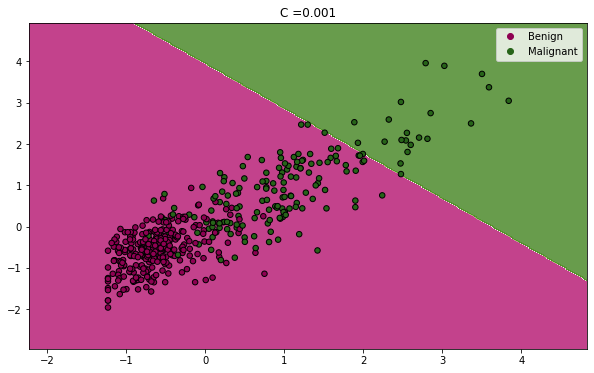

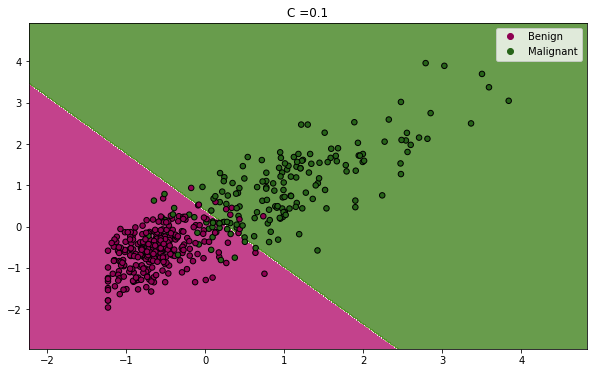

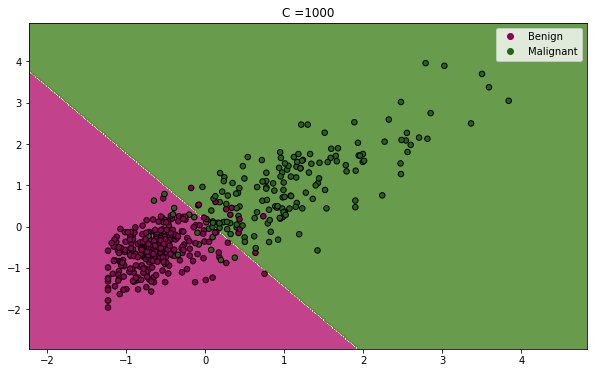

In [44]:
#Extract first two feature and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

Cs  = [0.001,0.1,1000]
for C in Cs:
    log_reg = LogisticRegression(penalty = "l2",max_iter = 1000, solver = "lbfgs", C=C) #will change parameters during CV
    log_reg.fit(train_2, target)
    
    draw_contour(train_2,target,log_reg, class_labels = ['Benign', 'Malignant'])
    plt.title(f"C ={C}")

We can see as the regularization strength changes, the decision boundary moves as well. Additionally, we can clearly see that the decision boundary is a line since this is a linear model.

## Models for Classification: SVM

We now discuss another type of linear classification model known as Support Vector Machines (SVM). Where Logistic Regression was motivated probability theory, SVM is motivated by geometeric arguments. Specifcally, SVM finds a separating hyperline that maximizes the margin (i.e. distance from each class). The hyperplane is used to classify the points by designating every sample on of side of the hyperplane as the positive class and the other side as the negative class.

The hyperplane is determine by a few sample points known as support vectors that uniquely characterize the hyperplane.


![svm_im](images/support-vector-machine-algorithm.png)


Note that it may not always be possible to find a hyperplane that completely separates the classes. Thus, we use what is known as Soft-Margin SVM which aims to maximize the margin while minizming the distance on the classes that are on the wrong side.

All Sci-kit learn implementations of SVM that we use are soft-margin SVM.

### Simple SVM classification 

In [45]:
svm = SVC()
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.921053


###  Parameters for SVM

In Sci-kit Learn, the following are just some of the parameters we can pass into Logistic Regression:

- C: positive float, default=1
    - Inverse of the regularization strength. You can treat C as $\frac{1}{\lambda}$ as shown in lecture. Thus, as C gets smaller, the regularization strength increases. SVM only uses the L2 regularization.
- kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}, default=’rbf’
    - Specifies the kernel type to be used in the algorithm. A kernel specifies a mapping into a higher dimension space to allow for non-linear decision boundaries.
- degree: int, default=3
    - Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
    

### Visualizing decision boundaries for SVM

Now, lets look at the decision boundary caused by SVM with different kernels. Same as for KNN and Logistic Regression, we use the two most correlated features to the target labels: concave_points_mean and perimeter_mean. This way, we can visualize the 2D decision boundary.


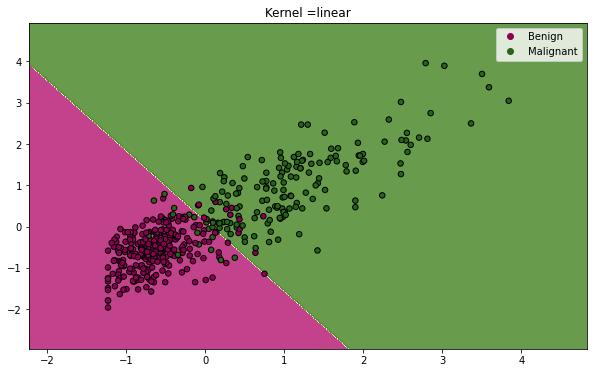

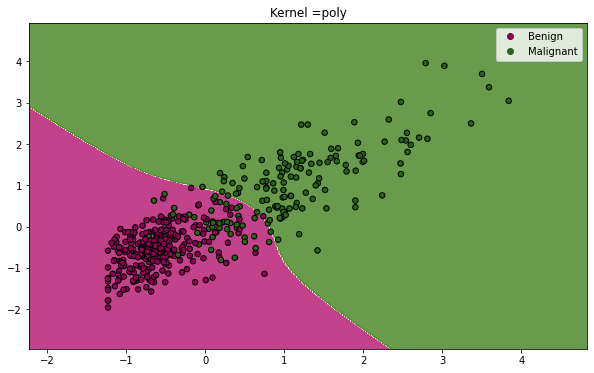

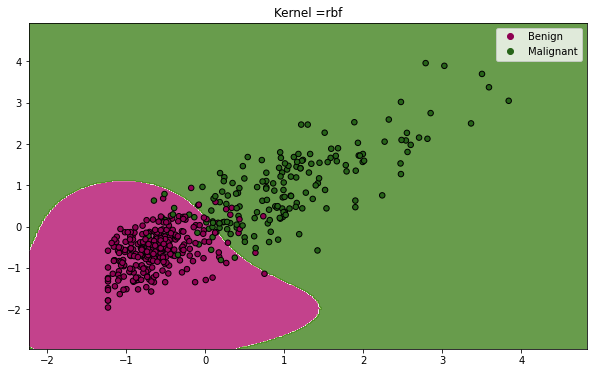

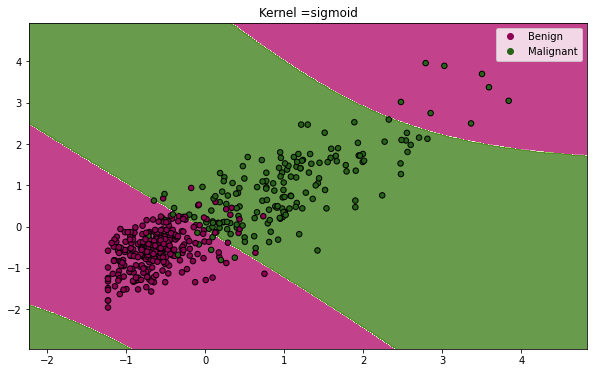

In [46]:
#Extract first two feature and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

kernel  = ['linear', 'poly', 'rbf',  'sigmoid']
for ker in kernel:
    svm = SVC(kernel = ker) #will change parameters during CV
    svm.fit(train_2, target)
    draw_contour(train_2,target,svm,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Kernel ={ker}")

We can see that the decision boundary is not always linear because we are using non-linear kernels.

## Important Measures for Classifications

Now that we have gone over a few models for binary classification, let's explore the different ways we can measure the performance of these models.

In [47]:
#Example classifier
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(train_raw, target)
predicted = log_reg.predict(test_raw)

Here are just some of the most important measures of interest. We use the convention to refer to the class labeled as $1$ as the positive class.

- **Accuracy:** The percentage of predictions that are correct. Use metrics.accuracy_score
- **Precision:** $\frac{\text{Number of labels correctly classified as positive}}{\text{Number of labels classified as positives}}$. Percentage of predictions that are correctly positive among all the predictions that were classified as positive. Use metrics.precision_score
- **Recall:** $\frac{\text{Number of labels correctly classified as positive}}{\text{Number of labels where the true class is positive}}$. Percentage of predictions that are correctly positive among all the labels where the true class is positive. Also known as the probability of detecting when a class is positive. Use metrics.recall_score
- **F1 Score:** Harmonic mean of the precision and recall. Highest value is $1$ when both precision and recall are $1$, i.e. perfect. Lowest value is $0$ when either precision or recall is zero. Provides an aggregate score to analyze both precision and recall. Use metrics.f1_score

We can calculate these measures by using a confusion matrix as well.

Accuracy:    0.938596
Precision:   0.888889
Recall:      0.952381
F1 Score:    0.919540
Confusion Matrix: 
 [[67  5]
 [ 2 40]]


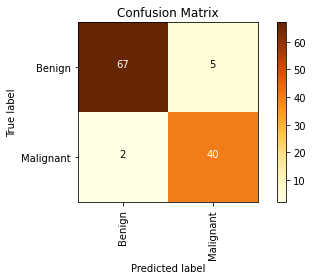

In [48]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(target_test,predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('Recall:', metrics.recall_score(target_test,predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("%-12s %f" % ('F1 Score:', metrics.f1_score(target_test,predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))

#Draws confusion matrix
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

# TODO: Using classification methods to classify heart disease

Now that you have some examples of the classifiers that Sci-kit learn has to offers, let try to apply them to a new dataset.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## [25 pts] Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [49]:
data = pd.read_csv('datasets/heartdisease.csv')

### [5 pts] Looking at the data 

Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method,  the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [50]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


In [51]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


**Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Additionally, some numerical features can represent categorical features which need to be pre-processed.  Are there any columns that need to be transformed and why?**

Every column except 'sick' is numeric. The 'sick' column will likely need to be transformed to numeric in order for it to be pre-processed. It may also be worth noting that other variables such as 'sex' are categorical variables, however, they are already being represented numerically and likely don't require transformation

**Determine if we're dealing with any null values. If so, report on which columns?**

In [53]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
sick        0
dtype: int64

In [54]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
sick        0
dtype: int64

There are not any null or na values in the data

### [5 pts] Transform target label into numerical value

Before we begin our analysis, we need to fix the field(s) that will be problematic. Specifically, convert our boolean "sick" variable into a binary numeric target variable (values of either '0' or '1') using the [label encoder from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), place this new array into a new column of the DataFrame named "target", and then drop the original "sick" column from the dataframe. Afterward, use .head to print the first 5 rows

In [55]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 

data['target'] = le.fit_transform(data['sick'])
data = data.drop(columns = ['sick'])

data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [56]:
print(le.classes_)

[False  True]


### [5 pts] Plotting histogram of data

Now that we have a feel for the data-types for each of the variables, plot histograms of each field.

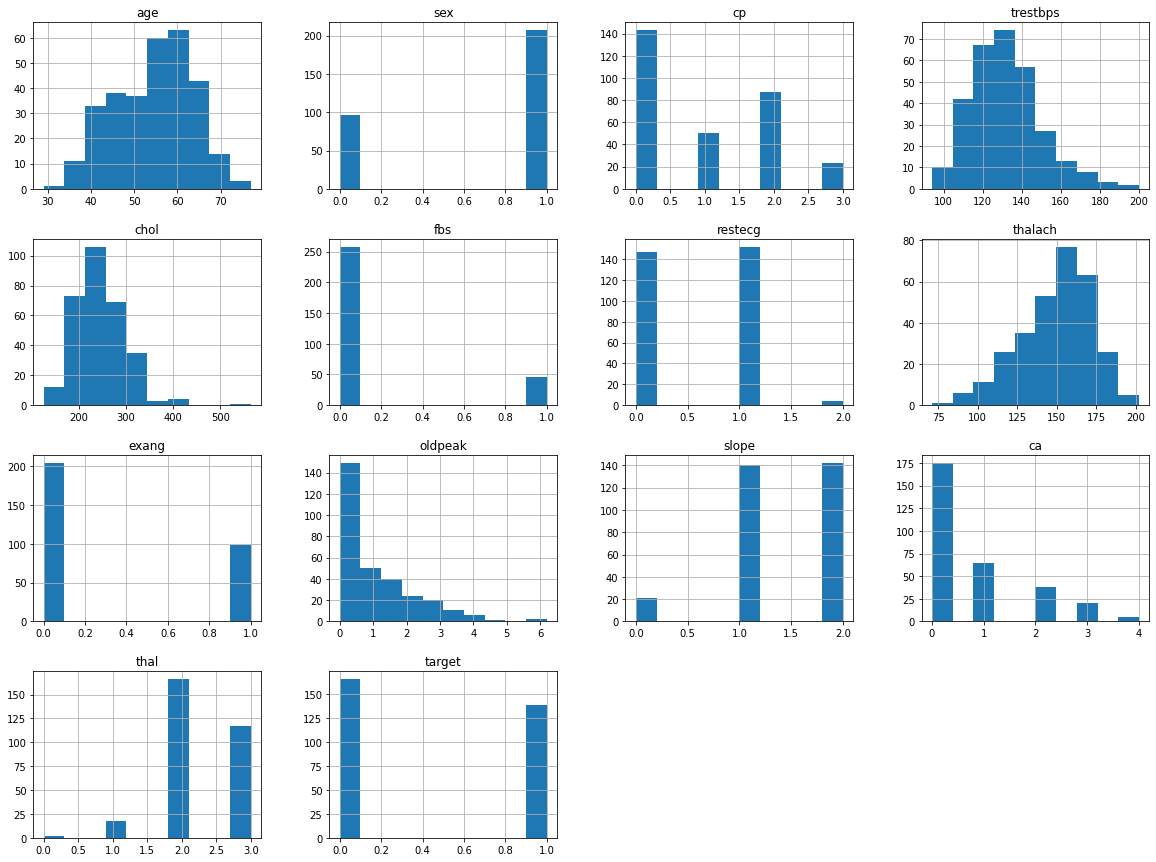

In [57]:
data.hist(figsize = (20,15))
plt.show()

### [5 pts] Looking at class balance

We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

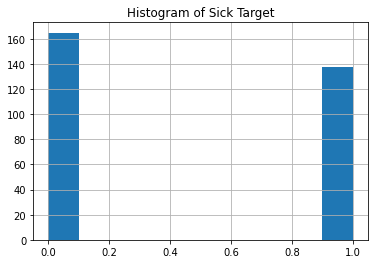

target
0    165
1    138
Name: count, dtype: int64

In [58]:
data['target'].hist()
plt.title('Histogram of Sick Target')
plt.show()
data['target'].value_counts()

Though the numbers are somewhat close, there are clearly fewer sick people than non-sick people in our data which we can visually see in the smaller bar corresponding to 1 in our histogram. The actual difference is 165 - 138 = 27

Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. 

**Discuss some of the problems that might arise by artificially balancing a dataset.**

By artifically balancing the dataset, we might lead to overfitting our model, as it may become too specialized and poorly generalize the data. There may also be a general loss of information by removing samples from the class with the majority counts, and we may introduce bias when we train our model due to it missing some data.

### [5 pts] Looking at Data Correlation

Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, use the heatmap function to plot the correlations of the data.

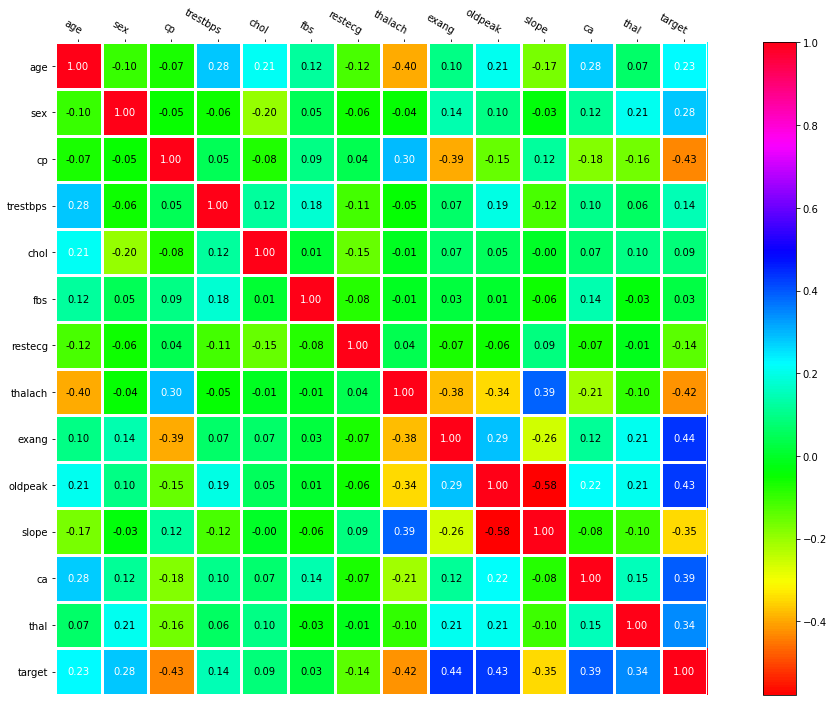

In [59]:
correlations = data.corr()
columns = list(data)
#Creates the heatmap
heatmap(correlations.values,columns,columns,figsize = (20,12),cmap="hsv")

Next, show the correlation to the "target" feature only and sorr them in descending order.

In [60]:
correlations["target"].sort_values(ascending=False)

target      1.000000
exang       0.436757
oldpeak     0.430696
ca          0.391724
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg    -0.137230
slope      -0.345877
thalach    -0.421741
cp         -0.433798
Name: target, dtype: float64

**From the heatmap values and the description of the features, why do you think some variables correlate more highly than others?**  (This question is just to get you thinking and there is no perfect answer since we have no medical background)

Off the bat, I'd note that it's interesting none of the features have a correlation stronger than 0.44 with target. To me, this may indicate that rather than any one thing affecting sickness severly,  many different features must play a role rather than any one thing, at least in a general sense. Examining the more strongly positively correlated features, it seems that biological issues induced by exercise play a significant role on sickness, slightly more than intrinsic factors like age and sex. This also seems to be the case as the most strongly negatively correlated features also have some relation to exercise as well.

## [25 pts] Part 2. Prepare the Data and run a KNN Model

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data. The first batch will simply be the raw numeric data that hasn't gone through any additional pre-processing. The second batch will be data that you will pipeline using pre-processing methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### [2 pts]  Separate target labels from data

Save the label column as a separate array and then make a new dataframe without the target.

In [61]:
y = data["target"]
x = data.drop(["target"],axis = 1)

### [5 pts] Balanced Train Test Split

Now, create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 60% of your total dataframe. To ensure that the train and test sets have balanced classes, use the [stratify command of train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Output the resulting shapes of your training and testing samples to confirm that your split was successful. Additionally, output the class counts for the training and testing cohorts to confirm that there is no artifical class imbalance.

Note: Use randomstate = 0 to ensure that the same train/test split happens everytime for ease of grading.

In [62]:
train_raw, test_raw, target, target_test = train_test_split(x, y, test_size = 0.4, stratify = y, random_state=0)

In [63]:
print("Training shape:", train_raw.shape)
print("Testing shape:", test_raw.shape)

Training shape: (181, 13)
Testing shape: (122, 13)


In [64]:
print("Training set class counts:", np.bincount(target))
print("Testing set class counts:", np.bincount(target_test))

Training set class counts: [99 82]
Testing set class counts: [66 56]


### [5 pts] KNN on raw data 

Now, let's try a classification model on this data. We'll first use KNN since it is the one we are most familiar with. 

One thing we noted in class was that because KNN relies on Euclidean distance, it is highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation, simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. **Report on the test accuracy of the resulting model and print out the confusion matrix.**

Recall that accurracy can be calculated easily using metrics.accuracy_score and that we have a helper function to draw the confusion matrix.

Accuracy:  0.6557377049180327


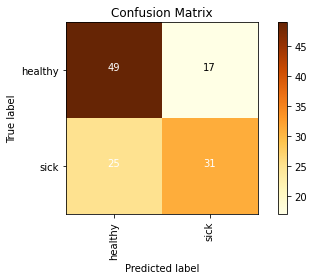

In [65]:
# k-Nearest Neighbors algorithm
knn = KNeighborsClassifier()
knn.fit(train_raw, target)
predicted = knn.predict(test_raw)

print("Accuracy: ", metrics.accuracy_score(target_test, predicted))
draw_confusion_matrix(target_test, predicted, classes = ['healthy', 'sick'])

### [5 pts] KNN on preprocessed data
Now lets implement a pipeline to preprocess the data. For the pipeline, use StandardScaler on the numerical features and one-hot encoding on the categorical features. For reference on how to make a pipeline, please look at project 1.

For reference, the categorical features are ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal'].

In [66]:
cat = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num), 
    ('cat', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore', categories = 'auto', drop = 'first'), cat)])

pipeline = Pipeline([('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=3))])

**Now use the pipeline to transform the data and then apply the same KNN classifier with this new training/testing data. Report the test accuraccy. Discuss the implications of the different results you are obtaining.**

Note: Remember to use fit_transform on the training data and transform on the testing data.

In [67]:
from sklearn.metrics import accuracy_score
train = pipeline['preprocessor'].fit_transform(train_raw)
test = pipeline['preprocessor'].transform(test_raw)

pipeline['knn'].fit(train, target)

predicted = pipeline['knn'].predict(test)

accuracy = accuracy_score(target_test, predicted)

print("Accuracy:", accuracy)

Accuracy: 0.7459016393442623


The accuracy is higher in this case, suggesting using the pre-processed data is more accurate

### [8 pts] KNN Parameter optimization for n_neighbors

The KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 7, 9, 10, 20, and 50. Run your model for each value and report the test accuracy for each. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [68]:
n_values = [1, 2, 3, 5, 7, 9, 10, 20, 50]
accuracies = []

for n in n_values:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train, target)
    
    predicted = knn.predict(test)
    
    accuracy = accuracy_score(target_test, predicted)
    accuracies.append(accuracy)

for n, accuracy in zip(n_values, accuracies):
    print(f"n_neighbors = {n}: Accuracy = {accuracy}")

n_neighbors = 1: Accuracy = 0.7131147540983607
n_neighbors = 2: Accuracy = 0.7131147540983607
n_neighbors = 3: Accuracy = 0.7459016393442623
n_neighbors = 5: Accuracy = 0.7459016393442623
n_neighbors = 7: Accuracy = 0.7786885245901639
n_neighbors = 9: Accuracy = 0.7868852459016393
n_neighbors = 10: Accuracy = 0.7704918032786885
n_neighbors = 20: Accuracy = 0.7704918032786885
n_neighbors = 50: Accuracy = 0.7704918032786885


**Comment for which value of n did the KNN model perform the best.  Did the model perform strictly better or stricly worse as the value of n increased?**

The best value of n is 9. The model does initially perform better for higher n, but it begins to drop as n increases after 9, so larger n does not necessarily give better accuracy

So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ Logistic Regression and SVM to improve upon the model and compare the results.

**For the rest of the project, you will only be using the transformed data and not the raw data. DO NOT USE THE RAW DATA ANYMORE.**

## [20 pts] Part 3. Additional Learning Methods:  Logistic Regression

Let's now try Logistic Regression. Recall that Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### [5 pts] Run the default Logistic Regression

Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model.  Use the default settings. **Report on the test accuracy and print out the confusion matrix.**

Test Accuracy: 0.7868852459016393


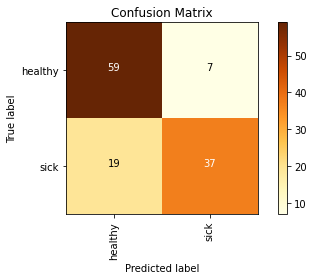

In [69]:
logreg = LogisticRegression()
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['healthy', 'sick'])

### [5 pts] Compare Logistic Regression and  KNN
In your own words, describe the key differences between Logistic Regression and KNN? When would you use one over the other?

Logistic regression is used for binary or multi-class classification problems and it models the relationship between input variables and the probability of belonging to a specific class. It does this via a logistic function and assumes linearity between features and the log of the target class. KNN is used for classification and regression and makes predictions based on the k-nearest data points in the training set. It determines the class of a new data point by the majority of its k nearest neighbors. Logistic regression would be best when the relationship between the features and the target is approximately linear while KNN is best when the decision boundary isn't linear and the data is distributed homogeneously.

### [5 pts] Tweaking the Logistic Regression

**What are some parameters we can change that will affect the performance of Logistic Regression?**

Some parameters we can change that will affect the performance of Logistic Regression are the regularization parameter C, the penalty, and/or the maximum number of iterations.


**Implement Logistic Regression with solver= 'liblinear', max_iter= 1000, penalty = 'l2', and C=1. Report on the test accuracy and print out the confusion matrix.**

Test Accuracy: 0.7786885245901639


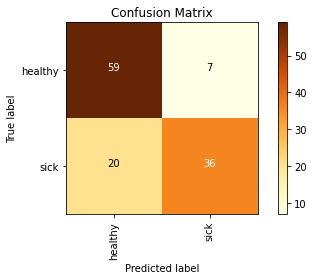

In [70]:
logreg = LogisticRegression(solver= 'liblinear', max_iter= 1000, penalty = 'l2', C=1)
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['healthy', 'sick'])

**Now, Implement Logistic Regression with solver= 'liblinear', max_iter= 1000, penalty = 'l2', and C=0.0001. Report on the test accuracy and print out the confusion matrix.**

Test Accuracy: 0.7786885245901639


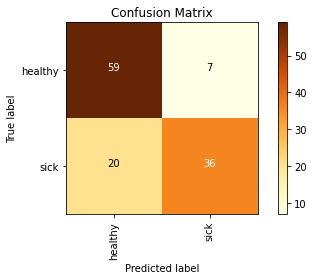

In [71]:
logreg = LogisticRegression(solver= 'liblinear', max_iter= 1000, penalty = 'l2', C=0.0001)
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['healthy', 'sick'])

**Did the accuraccy drop or improve? Why?**

In this case the accuracy remained the same suggesting the model performance isn't greatly affected by regularization strength. Perhaps the data is already well seperated and is not likely to overfit.

### [5 pts] Trying out different penalties

**Now, Implement Logistic Regression with solver= 'liblinear', max_iter= 1000, penalty = 'l1', and C=1. Report on the test accuracy and print out the confusion matrix.**

Test Accuracy: 0.5409836065573771


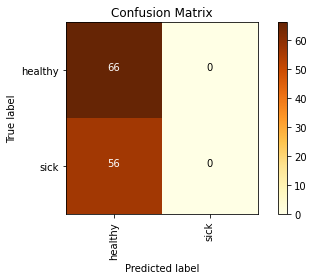

In [72]:
logreg = LogisticRegression(solver= 'liblinear', max_iter= 1000, penalty = 'l1', C=0.0001)
logreg.fit(train, target)

predicted = logreg.predict(test)

accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['healthy', 'sick'])

**Describe what the purpose of a penalty term is and how the change from L2 to L1 affected the model.**

The penalty term exists for regualrization and is meant to prevent overfitting of the model. L2 penalizes coefficients but does not drive them to be 0, while L1 can drive them to be 0. So, L2 will keep all the features in the model while L1 may not, which seems to be reflected in the lower accuracy of our logistic regression with L1 penalty

## [20 pts] Part 4. Additional Learning Methods:  SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimensional space this hyperplane is a line dividing a plane in two parts each corresponding to one of the two classes.

Recall that Sci-kit learn uses soft-margin SVM to account for datasets that are not separable. 

### [5 pts] Run default SVM classifier

Implement a Support Vector Machine classifier on your pipelined data. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings. **Report on the test accuracy and print out the confusion matrix.**

In [73]:
svm = SVC()
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.795082


**Print out the number of support vectors that SVC has determined. Look at the documentation for how to get this.**

In [74]:
print("Number of support vectors:", svm.n_support_)

Number of support vectors: [54 59]


You may find that there are quite a few support vectors. This is due in part to the small number of samples in the training set and the choice of kernel.

### [5 pts] Use a Linear SVM

Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. **Report on the test accuracy and print out the confusion matrix. Also, print out the number of support vectors.**

In [75]:
svm = SVC(kernel = 'linear')
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Number of support vectors:", svm.n_support_)

Accuracy:    0.827869
Number of support vectors: [36 37]


You will notice that number of support vectors has decreased significantly. 

### [5 pts] Compare default SVM and Linear SVM

Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

By changing the kernel to linear, the SVM model now uses a linear kernel function as a decision boundary and the kernel now assumes the data can be seperated by a straight (linear) line. 

### [5 pts] Compare SVM and Logistic Regression

Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary but achieve it in different ways. In your own words, explain the difference between the ways that Logistic Regression and Linear SVM find the boundary?

Logistic regression models the probability of a data point belonging to a particular class, and the decision boundary is determined by a threshold where data points with probabilities above the threshold are classified as positive, and those below are classified as negative. Linear SVM looks for the ideal hyperplane seperating classes, and it finds the decision boundary by solving an optimization problem where it finds the support vectors and maximizes the distance between those vectors and the boundary.

## [10 pts] Part 5: Cross Validation and Model Selection

You've sampled a number of different classification techniques and have seen their performance on the dataset. 
Before we draw any conclusions on which model is best, we want to ensure that our results are not the result of the random sampling of our data we did with the Train-Test-Split. To ensure otherwise, we will conduct a K-Fold Cross-Validation with GridSearch to determine which model perform best and assess its performance on the test set.

### [10 pts]  Model Selection

Run a GridSearchCV with 3-Fold Cross Validation. You will be running each classification model with different parameters. 

KNN:
- n_neighbors = [1,3,5,7]
- metric = ["euclidean","manhattan"] #Different Distance functions

Logistic Regression:
- penalty = ["l1","l2"]
- solver = ["liblinear"]
- C = [0.0001,0.1,10]

SVM:
- kernel = ["linear","rbf"]
- C = [0.0001,0.1,10]


Make sure to train and test your model on the transformed data and not on the raw data.

After using GridSearchCV, put the results into a pandas Dataframe and print out the whole table.

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [1, 3, 5, 7],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear'],
            'C': [0.0001, 0.1, 10]
        }
    },
    'SVM': {
        'model': SVC(),
        'param_grid': {
            'kernel': ['linear', 'rbf'],
            'C': [0.0001, 0.1, 10]
        }
    }
}

results = {}  

for model_name, model_params in param_grid.items():
    grid_search = GridSearchCV(model_params['model'], model_params['param_grid'], cv=3)
    grid_search.fit(train, target)
    results[model_name] = grid_search.cv_results_

df_results = pd.DataFrame(results)

print(df_results)

                                                                 KNN   
mean_fit_time      [0.0017549991607666016, 0.0008312861124674479,...  \
std_fit_time       [0.0008632115130064118, 3.863574525171834e-05,...   
mean_score_time    [0.0051259199778238935, 0.00392913818359375, 0...   
std_score_time     [0.000850202710839819, 0.00027363688544647933,...   
param_metric       [euclidean, euclidean, euclidean, euclidean, m...   
param_n_neighbors                           [1, 3, 5, 7, 1, 3, 5, 7]   
params             [{'metric': 'euclidean', 'n_neighbors': 1}, {'...   
split0_test_score  [0.7868852459016393, 0.7704918032786885, 0.819...   
split1_test_score  [0.7333333333333333, 0.6833333333333333, 0.766...   
split2_test_score  [0.75, 0.8166666666666667, 0.8333333333333334,...   
mean_test_score    [0.7567395264116575, 0.7568306010928962, 0.806...   
std_test_score     [0.02237584630981878, 0.05528360684274779, 0.0...   
rank_test_score                             [8, 7, 3, 5, 6, 4, 1

**What was the best model and what was it's score?**

In [77]:
print("Best model:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

Best model: SVC(C=10, kernel='linear')
Best score: 0.8178506375227688


**Using the best model you have, report the test accuracy and print out the confusion matrix**

Test Accuracy: 0.819672131147541


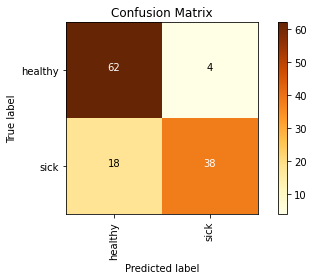

In [78]:
best_model = grid_search.best_estimator_

predicted = best_model.predict(test)

test_accuracy = accuracy_score(target_test, predicted)
print("Test Accuracy:", test_accuracy)

draw_confusion_matrix(target_test, predicted, classes = ['healthy', 'sick'])